# 생물정보학 및 실습 1 - Final Project

생물정보학
2022-38072
장성은

```
생물정보학 및 실습 1
서울대학교 생물정보학전공/생명과학부 2024년 1학기

이 노트북은 Creative Commons BY-SA 조건으로 재사용 가능합니다.
장혜식 <hyeshik@snu.ac.kr>, 서울대학교 생명과학부
```



## Google Drive 마운트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 실습용 Bioconda 환경 설치하기

In [ ]:
!git clone https://github.com/hyeshik/colab-biolab.git
!cd colab-biolab && bash tools/setup.sh
exec(open('colab-biolab/tools/activate_conda.py').read())

Cloning into 'colab-biolab'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 76 (delta 26), reused 59 (delta 15), pack-reused 0
Receiving objects: 100% (76/76), 318.16 KiB | 1.64 MiB/s, done.
Resolving deltas: 100% (26/26), done.
./
./root/
./root/.condarc
./root/.bin.priority/
./root/.bin.priority/pip3
./root/.bin.priority/pip2
./root/.bin.priority/pip
./root/.profile
./root/.tmux.conf
./root/.bashrc.biolab
./root/.vimrc
--2024-05-30 07:26:18--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.32.241, 104.16.191.158, 2606:4700::6810:20f1, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.32.241|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143808873 (137M) [application/octet-stream]
Saving to: ‘miniconda3.sh’

miniconda3.sh       100%[===================>] 137.15M   

# 프로그램 설치


In [ ]:
!conda install -y bedtools bioawk samtools subread

In [ ]:
!pip install pysam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 31.5 MB/s eta 0:00:00


In [ ]:
!pip install logomaker

## Figure S3C 재현하기

Transcriptome에서 error가 많이 나오는 부분들 주변 서열을 모아서 문맥을 파악합니다.


To better understand LIN28A-RNA interactions, we further
analyzed patterns around the potential LIN28A binding sites
(Figures 2A and S3C). The frequently mutated G is preceded
by two bases with strong preference for A or U and is followed
by three bases favoring G or A.

Consensus of confident binding sites from individual CLIP-seq libraries

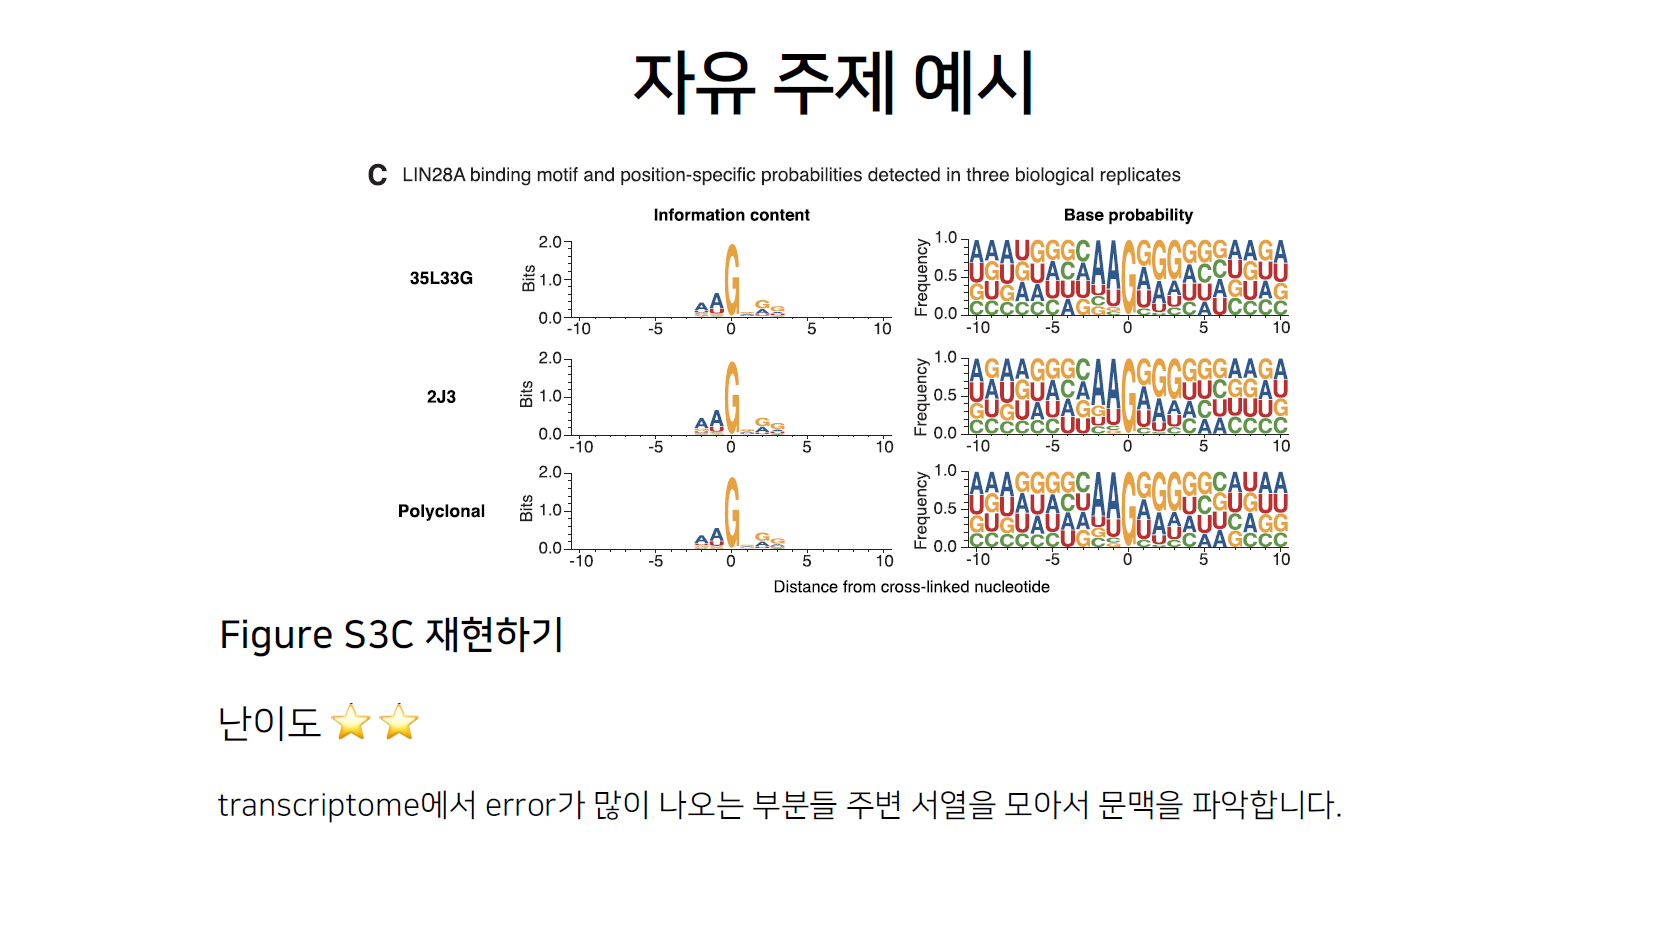

In [ ]:
%cd drive/MyDrive/temp/2024-Bioinfo-1/Project/binfo1-datapack1

/content/drive/MyDrive/temp/2024-Bioinfo-1/Project/binfo1-datapack1


In [ ]:
!ls

CLIP-35L33G.bam		gencode.gtf		 RNA-siLin28a.bam      RPF-siLin28a.bam.bai
CLIP-35L33G.bam.bai	read-counts.txt		 RNA-siLin28a.bam.bai  RPF-siLuc.bam
CLIP-let7g.bam		read-counts.txt.summary  RNA-siLuc.bam	       RPF-siLuc.bam.bai
CLIP-let7g-gene.pileup	RNA-control.bam		 RNA-siLuc.bam.bai
CLIP-let7g.pileup	RNA-control.bam.bai	 RPF-siLin28a.bam


In [ ]:
import pysam
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

# BAM 파일 열기
bamfile = pysam.AlignmentFile("RNA-control.bam", "rb")

# 에러 위치 및 서열 추출
error_positions = []
context_sequences = []
max_seq_length = 0

for read in bamfile.fetch():
    if read.mapping_quality < 20:  # 예시로 mapping quality가 20 미만인 경우 에러로 간주
        error_position = read.reference_start
        surrounding_sequence = read.query_sequence
        error_positions.append(error_position)
        context_sequences.append(surrounding_sequence)
        max_seq_length = max(max_seq_length, len(surrounding_sequence))

bamfile.close()

# 에러 빈도 계산
error_counts = Counter(error_positions)

# 히트맵 데이터 생성
unique_positions = sorted(list(set(error_positions)))
num_positions = len(unique_positions)
heatmap_data = np.full((num_positions, max_seq_length), ord('N'))  # 기본값으로 'N' 패딩

position_index = {position: idx for idx, position in enumerate(unique_positions)}

for seq, position in zip(context_sequences, error_positions):
    row_idx = position_index[position]
    # 서열을 max_seq_length로 맞추기
    padded_sequence = seq.ljust(max_seq_length, 'N')
    heatmap_data[row_idx] = [ord(base) for base in padded_sequence]  # 여기서 전체 길이 사용

# 히트맵 시각화
fig, ax = plt.subplots(figsize=(12, 8))
cax = ax.matshow(heatmap_data, cmap='viridis', aspect='auto')
fig.colorbar(cax)

# X축과 Y축의 레이블 설정
ax.set_xticks(np.arange(max_seq_length))
ax.set_xticklabels([str(i) for i in range(max_seq_length)], rotation=90)
ax.set_yticks(np.arange(num_positions))
ax.set_yticklabels([str(pos) for pos in unique_positions])

plt.xlabel('Base Position in Sequence')
plt.ylabel('Error Position')
plt.title('Sequence Context Around Errors')
plt.tight_layout()
plt.show()


In [ ]:
import pysam
import pandas as pd
import logomaker

# BAM 파일 열기
bamfile = pysam.AlignmentFile("RNA-control.bam", "rb")

# 에러 위치 및 서열 추출
error_positions = []
context_sequences = []
max_seq_length = 0

for read in bamfile.fetch():
    if read.mapping_quality < 20:  # 예시로 mapping quality가 20 미만인 경우 에러로 간주
        error_position = read.reference_start
        surrounding_sequence = read.query_sequence
        error_positions.append(error_position)
        context_sequences.append(surrounding_sequence)
        max_seq_length = max(max_seq_length, len(surrounding_sequence))

bamfile.close()

# 에러 빈도 계산
error_counts = Counter(error_positions)

# 모티프 데이터를 만들기 위해 서열을 고정 길이로 맞추기
max_motif_length = max_seq_length  # 모티프 길이 설정
motif_sequences = [seq.ljust(max_motif_length, 'N') for seq in context_sequences]

# 염기 빈도수 계산
bases = ['A', 'C', 'G', 'T', 'N']
motif_df = pd.DataFrame(0, index=range(max_motif_length), columns=bases)

for seq in motif_sequences:
    for i, base in enumerate(seq):
        if base in bases:
            motif_df.at[i, base] += 1

# 모티프 빈도수를 비율로 변환
motif_df = motif_df.div(motif_df.sum(axis=1), axis=0)

# 로고메이커를 사용한 모티프 시각화
logo = logomaker.Logo(motif_df)

# 이미지 출력
logo.style_spines(visible=False)
logo.style_spines(spines=['left', 'bottom'], visible=True)
logo.style_xticks(rotation=90, fmt='%d')
logo.ax.set_ylabel('Frequency')
logo.ax.set_title('Sequence Logo Around Errors')

plt.show()


In [ ]:
import pysam
import pandas as pd
import logomaker

# GTF 파일을 사용하여 전사체 영역 로드
def load_transcriptome_regions(gtf_file):
    transcriptome_regions = []
    with open(gtf_file, 'r') as f:
        for line in f:
            if line.startswith('#'):
                continue
            fields = line.strip().split('\t')
            if fields[2] == 'exon':  # Exon 정보를 사용하여 전사체 영역 추출
                chrom = fields[0]
                start = int(fields[3])
                end = int(fields[4])
                transcriptome_regions.append((chrom, start, end))
    return transcriptome_regions

# BAM 파일 열기 및 전사체 영역에서 리드 추출
def extract_transcriptome_reads(bam_file, transcriptome_regions):
    bamfile = pysam.AlignmentFile(bam_file, "rb")
    reads = []
    for region in transcriptome_regions:
        chrom, start, end = region
        for read in bamfile.fetch(chrom, start, end):
            if read.mapping_quality < 20:  # 예시로 mapping quality가 20 미만인 경우 에러로 간주
                reads.append(read)
    bamfile.close()
    return reads

# 전사체 영역 로드 (GTF 파일 필요)
transcriptome_regions = load_transcriptome_regions("gencode.gtf")

# BAM 파일에서 전사체 리드 추출
bamfile = pysam.AlignmentFile("RNA-control.bam", "rb")

# 에러 위치 및 서열 추출
error_positions = []
context_sequences = []
max_seq_length = 0

for read in transcriptome_reads:
    error_position = read.reference_start
    surrounding_sequence = read.query_sequence
    error_positions.append(error_position)
    context_sequences.append(surrounding_sequence)
    max_seq_length = max(max_seq_length, len(surrounding_sequence))

# 모티프 데이터를 만들기 위해 서열을 고정 길이로 맞추기
max_motif_length = max_seq_length  # 모티프 길이 설정
motif_sequences = [seq.ljust(max_motif_length, 'N') for seq in context_sequences]

# 염기 빈도수 계산
bases = ['A', 'C', 'G', 'T', 'N']
motif_df = pd.DataFrame(0, index=range(max_motif_length), columns=bases)

for seq in motif_sequences:
    for i, base in enumerate(seq):
        if base in bases:
            motif_df.at[i, base] += 1

# 모티프 빈도수를 비율로 변환
motif_df = motif_df.div(motif_df.sum(axis=1), axis=0)

# 로고메이커를 사용한 모티프 시각화
logo = logomaker.Logo(motif_df)

# 이미지 출력
logo.style_spines(visible=False)
logo.style_spines(spines=['left', 'bottom'], visible=True)
logo.style_xticks(rotation=90, fmt='%d')
logo.ax.set_ylabel('Frequency')
logo.ax.set_title('Sequence Logo Around Errors')

plt.show()